<a href="https://colab.research.google.com/github/Tottoro932/Neural-networks/blob/main/Lab_2_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Lab 2_1: MXNet Basic Classification**

In [1]:
!pip install mxnet   # автоматизирует рабочие процессы => нейронная сеть занимает мало строчек кода

     |████████████████████████████████| 46.9 MB 43 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
# импорт библиотек
import mxnet as mx
from mxnet.gluon.data.vision import transforms

from mxnet import nd, gluon, autograd
from mxnet.gluon import nn

import pickle  # формат для выгрузки данных из памяти на диск и обратно

import numpy as np
import matplotlib.pyplot as plt   # для отображения графиков


In [3]:
# загрузили датасеты
mnist = mx.test_utils.get_mnist()

In [4]:
# данные поступают в виде массива 28х28, мы их преобразуем в плоскую структуру 1х784
train_d = mnist['train_data'].reshape((-1, 784))
train_data = mx.nd.array(train_d)

train_l = mx.nd.array(mnist['train_label'])
train_label = mx.nd.array(train_l)

test_d = mnist['test_data'].reshape((-1, 784))
test_data = mx.nd.array(test_d)

test_l = mnist['test_label']
test_label = mx.nd.array(test_l)

In [5]:
#train_fh = mx.io.NDArrayIter(data = {'train_data': mnist['train_data']}, label = {'train_label': mnist['train_label']},batch_size = 100)
#test_fh = mx.io.NDArrayIter(data = {'test_data': mnist['test_data']},label = {'test_label': mnist['test_label']})

batch_size = 34
#train_data = mx.io.NDArrayIter(train_data, train_label, batch_size, shuffle=True)
#val_data = mx.io.NDArrayIter(test_data, test_label, batch_size)

train_dataset = gluon.data.ArrayDataset(train_data, train_label) # создаем тренировочный датасет
train_ = gluon.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [6]:
# задали имена классов (10 штук)
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] 


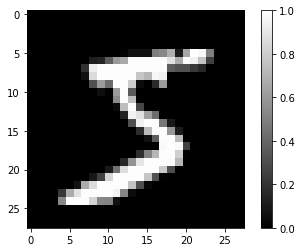

ответ: 5.0


In [11]:
train_image_no = 0  # задаем номер картинки, которую хотим вывести
 
images_data = train_data[train_image_no] 
plt.figure() 
plt.imshow(images_data.reshape((28,28)).asnumpy(),cmap='gray') # выводим картинку на экран, 28 на 28 пикселей
plt.colorbar() 
 
plt.show() 
print("ответ:", train_label[train_image_no].asnumpy()[0])


In [12]:
# создаем модель нейронной сети из 3 последовательных слоев
net = nn.HybridSequential(prefix='MLP_') 
with net.name_scope(): 
   net.add( 
     nn.Flatten(), # переводим в векторную форму
     nn.Dense(128, activation='relu'), # первый слой: 128 нейронов, функция активации (чтобы уйти от линейной зависимости)
     nn.Dense(64, activation='relu'), # второй слой: 128 нейронов, relu: 0 - отриц.при аргументах <0 и само значение при аргументах >0
     nn.Dense(10, activation=None)     # второй слой: 128 нейронов, не содержит активации
   ) 
   # nn - функция mxnet, отвечает за создание нейронных сетей


In [13]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0) 
net.initialize(mx.init.Xavier(), ctx=ctx)

In [14]:
trainer = gluon.Trainer(  # trainer проводит оптимизацию параметров
  params=net.collect_params(), # возвращает параметры net (количество узлов матрицы коэффициентов)
  optimizer='sgd', 
  optimizer_params={'learning_rate': 0.04}, # задали скорость тренировки 0.04
) 

In [15]:
# метрики для отслеживания обучения сети (на сколько хорошо обучается)
metric = mx.metric.Accuracy() # accuracy - точность
loss_function = gluon.loss.SoftmaxCrossEntropyLoss() # функция потерь (на сколько каждая картинка отличается от ожидаемого результата)


In [16]:
# начинаем обучение
num_epochs = 10 # количество эпох (10 раз просматриваем датасет перед тем как завершить обучение)
history = [] 
 
for epoch in range(num_epochs):    # цикл по эпохам
  for inputs, labels in train_:   # train_ - подгрузка данных из датасета порциями
    
    inputs = inputs.as_in_context(ctx) 
    labels = labels.as_in_context(ctx) 
 
    with autograd.record(): 
      outputs = net(inputs) 
      loss = loss_function(outputs, labels) 
 
    # оцениваем функцию потерь и делаем корректировку
    loss.backward() 
    metric.update(labels, outputs) # обновляем метрику (следим за качеством на каждом шаге)
 
    
    trainer.step(batch_size=inputs.shape[0]) # trainer - следит за состоянием тренировки (обновляем каждый раз)
 
  name, acc = metric.get() # точность рассчитывается через метрику
  history.insert(epoch,acc) # на каждом шаге вставляем в массив номер эпохи и текущее значение точности
  print('.', end='') 
  metric.reset() 
 
print('[Done]')

..........[Done]


Text(0.5, 0, 'Epoch')

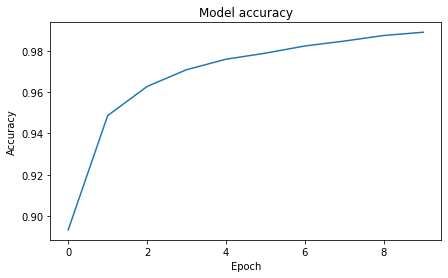

In [17]:
plt.figure(figsize=(7, 4)) 
plt.plot(history) # массив с предыдущего шага
plt.title('Model accuracy') 
plt.ylabel('Accuracy') 
plt.xlabel('Epoch') 
# как менялась точность с количеством эпох 
# с 6 эпохи точность почти не менялась

In [21]:
# из тестовых данных подгружаем результаты для проверки качества нашей сети
test_dataset = gluon.data.ArrayDataset(test_data, test_label) # создаем тренировочный датасет
test_ = gluon.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [22]:
# повторям тот же процесс что и при обучении
metric = mx.metric.Accuracy() 

for inputs, labels in test_: 
  
  inputs = inputs.as_in_context(ctx) 
  labels = labels.as_in_context(ctx) 
  metric.update(labels, net(inputs)) 
 
print('Validation: {} = {}'.format(*metric.get()))
# на выходе получаем точность результатов

Validation: accuracy = 0.9761
